In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import matplotlib.pyplot as plt

In [3]:
data=pd.read_excel(r"C:\Users\Vanshi\OneDrive\Desktop\ONION\HARYANA 1.xlsx")

In [4]:
# Convert 'Reported Date' to datetime and sort by it
data['Reported Date'] = pd.to_datetime(data['Reported Date'])
data = data.sort_values(by='Reported Date')

In [5]:
# Handle missing values
data['Max Price (Rs./Quintal)'].fillna(data['Max Price (Rs./Quintal)'].mean(), inplace=True)

In [6]:
# Selecting the relevant columns for LSTM: 'Reported Date' and 'Max Price (Rs./Quintal)'
price_data = data[['Reported Date', 'Max Price (Rs./Quintal)']].set_index('Reported Date')

In [7]:
# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(price_data)

<Axes: xlabel='Reported Date'>

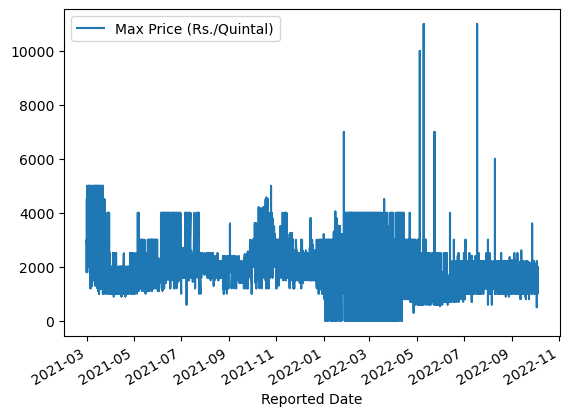

In [23]:
price_data.plot()

In [24]:
from statsmodels.tsa.stattools import adfuller

In [25]:
test_result=adfuller(data['Max Price (Rs./Quintal)'])

In [ ]:
def adfuller_test(Max Price (Rs./Quintal)):
    result=adfuller(M)

In [8]:
# Function to create sequences of data for LSTM
def create_sequences(data, time_step=1):
    x, y = [], []
    for i in range(len(data) - time_step - 1):
        x.append(data[i:(i + time_step), 0])
        y.append(data[i + time_step, 0])
    return np.array(x), np.array(y)

In [9]:
# Set the time step (previous days used to predict the next day's price)
time_step = 10
X, y = create_sequences(scaled_data, time_step)

In [10]:
# Reshape X for LSTM [samples, time steps, features]
X = X.reshape(X.shape[0], X.shape[1], 1)

In [11]:
# Split the data into training and testing sets (80% training, 20% testing)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

In [12]:
# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(time_step, 1)))
model.add(LSTM(units=50))
model.add(Dense(1))

C:\Users\Vanshi\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [13]:
# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

In [14]:
# Train the model
model.fit(X_train, y_train, epochs=20, batch_size=64, verbose=1)

Epoch 1/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 7s 10ms/step - loss: 0.0061
Epoch 2/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028
Epoch 3/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0028
Epoch 4/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0027
Epoch 5/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step - loss: 0.0028
Epoch 6/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 9ms/step - loss: 0.0028
Epoch 7/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0027
Epoch 8/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16ms/step - loss: 0.0029
Epoch 9/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.0028
Epoch 10/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0029
Epoch 11/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0028
Epoch 12/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 12ms/step - loss: 0.0027
Epoch 13/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0028
Epoch 14/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 13ms/step - loss: 0.0027
Epoch 15/20
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 16

In [15]:
# Make predictions
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

381/381 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step
96/96 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [16]:
# Inverse transform the predictions and actual values for evaluation
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform([y_train])
y_test = scaler.inverse_transform([y_test])

In [17]:
# Calculate RMSE (Root Mean Squared Error)
train_rmse = np.sqrt(np.mean((train_predict - y_train.T)**2))
test_rmse = np.sqrt(np.mean((test_predict - y_test.T)**2))

print(f'Training RMSE: {train_rmse}')
print(f'Testing RMSE: {test_rmse}')

Training RMSE: 581.4899541854859
Testing RMSE: 373.49714435550203


In [21]:
# Step 3: Calculate R-squared
from sklearn.metrics import r2_score
r_squared = r2_score(test_predict, y_test.T)

print(f'R-squared: {r_squared:.4f}')

R-squared: -15.6342
